## Итоговый проект по курсу GeekBrains Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn
Задание для курсового проекта <br>
Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Сдача проекта: <br>
<ul>
<li>Срок сдачи: 05.02.2021</li>
<li>Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook </li>
<li>Необходимо получить R2 > 0.6 на Private Leaderboard  </li>
<li>Ник на kaggle - yariknedoma</li>
<li>Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.</li></ul>

### Рекомендации для файла с кодом (ipynb):<br>
<ul>
    <li>Файл должен содержать заголовки и комментарии</li>
<li>Повторяющиеся операции лучше оформлять в виде функций</li>
<li>По возможности добавлять графики, описывающие данные (около 3-5)</li>
<li>Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта</li>
<li>Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)</li>
<li>Весь проект должен быть в одном скрипте (файл ipynb).</li>
<li>При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.</li>
<li>Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.</li></ul>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder
from scipy import stats

%matplotlib inline

In [30]:
full_data = pd.read_csv('train.csv')
full_test = pd.read_csv('test.csv')

## Train data preprocessing

In [31]:
data = full_data.copy()

## DROPING ID COLUMN
data.drop('Id', axis=1, inplace=True)

## DROPING A HEALTHCARE_1 COL
data.drop('Healthcare_1', axis=1, inplace=True)

# SETTING ROOMS and HOUSEFLOOR TO INT 32
data['Rooms'] = data['Rooms'].astype('int32')
data['HouseFloor'] = data['HouseFloor'].astype('int32')

# DEALING WITH CAT_FEATURES
object_cols = list(data.dtypes[data.dtypes=='object'].index)
ord_encoder = OrdinalEncoder()
new_cols = pd.DataFrame(ord_encoder.fit_transform(data[object_cols]))
new_cols.columns = data[object_cols].columns
data = data.drop(object_cols, axis=1)
data = pd.concat([data, new_cols], axis=1)
data[object_cols] = data[object_cols].astype('int32')

# SETTING THE HOUSEFLOOR = FLOOR WHERE HOUSEFLOOR<FLOOR OR 0
data.loc[data[data['Floor']>data['HouseFloor']].index, 'HouseFloor'] = data['Floor']

## Test data preprocessing

In [32]:
data1 = full_test.copy()

## DROPING ID COLUMN
data1.drop('Id', axis=1, inplace=True)

## DROPING A HEALTHCARE_1 COL
data1.drop('Healthcare_1', axis=1, inplace=True)

# SETTING ROOMS and HOUSEFLOOR TO INT 32
data1['Rooms'] = data1['Rooms'].astype('int32')
data1['HouseFloor'] = data1['HouseFloor'].astype('int32')

# DEALING WITH CAT_FEATURES
object_cols = list(data1.dtypes[data1.dtypes=='object'].index)
ord_encoder = OrdinalEncoder()
new_cols = pd.DataFrame(ord_encoder.fit_transform(data1[object_cols]))
new_cols.columns = data1[object_cols].columns
data1 = data1.drop(object_cols, axis=1)
data1 = pd.concat([data1, new_cols], axis=1)
data1[object_cols] = data1[object_cols].astype('int32')

# SETTING THE HOUSEFLOOR = FLOOR WHERE HOUSEFLOOR<FLOOR OR 0
data1.loc[data1[data1['Floor']>data1['HouseFloor']].index, 'HouseFloor'] = data1['Floor']

### Train data columns before and after preprocessing

In [33]:
full_data[['Rooms', 'HouseFloor', 'Ecology_2', 'Ecology_3', 'Shops_2']].head()

,Rooms,HouseFloor,Ecology_2,Ecology_3,Shops_2
0,2.0,9.0,B,B,B
1,3.0,9.0,B,B,B
2,2.0,12.0,B,B,B
3,2.0,17.0,B,B,B
4,1.0,12.0,B,B,B


In [34]:
data[['Rooms', 'HouseFloor', 'Ecology_2', 'Ecology_3', 'Shops_2']].head()

,Rooms,HouseFloor,Ecology_2,Ecology_3,Shops_2
0,2,9,1,1,1
1,3,9,1,1,1
2,2,12,1,1,1
3,2,17,1,1,1
4,1,12,1,1,1


## Checking for outliers in data

In [35]:
data_no_nans = data[data['LifeSquare'].notnull()==True]

In [36]:
data_no_nans.shape

(7887, 18)

In [37]:
features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 
            'HouseFloor', 'HouseYear', 'Helthcare_2', 'Shops_1']

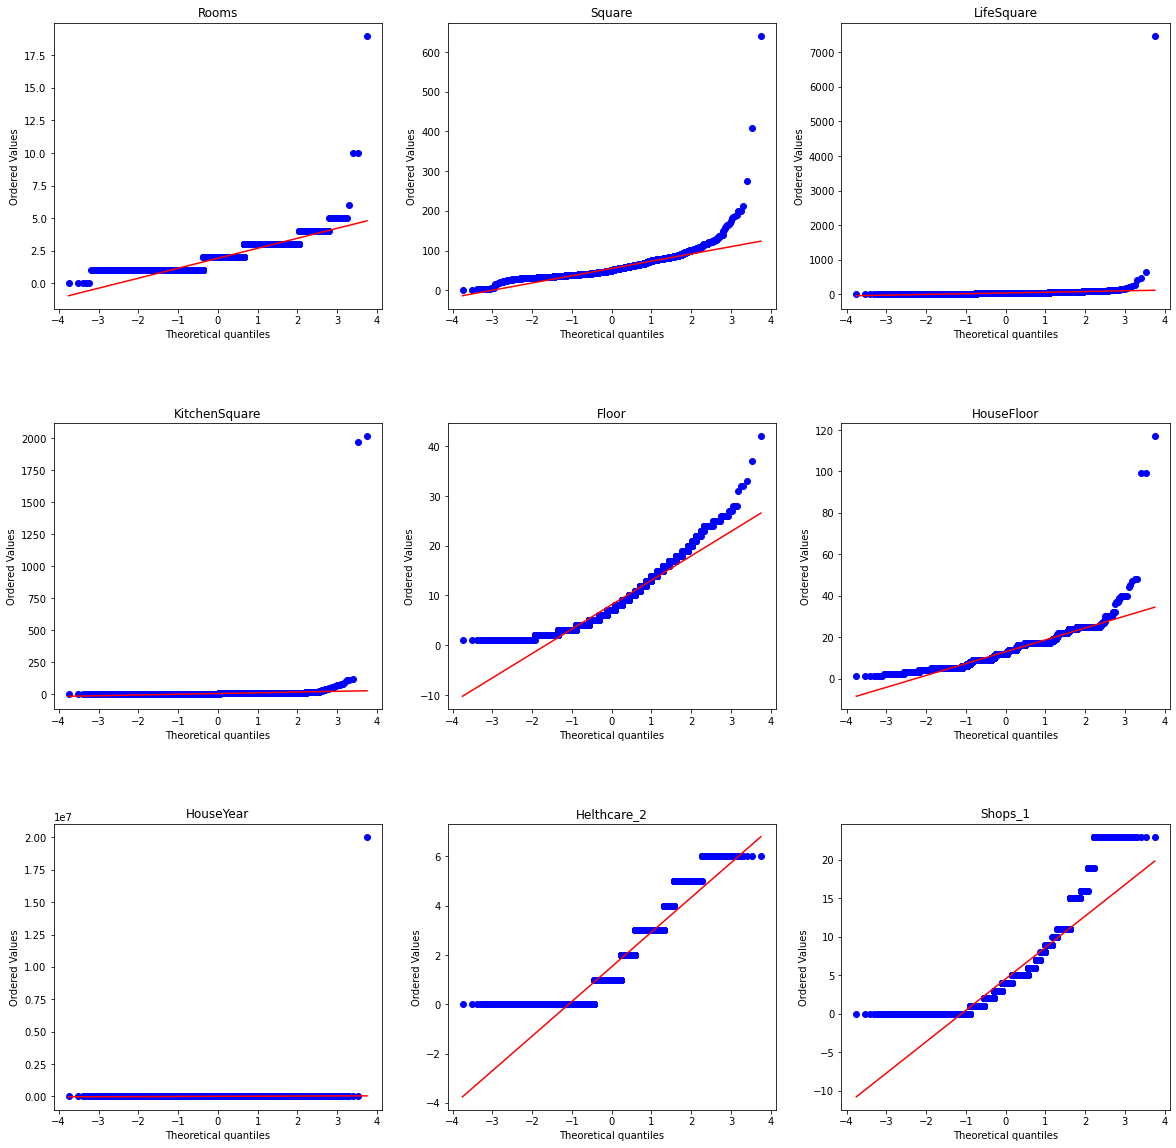

In [38]:
import scipy
from scipy import stats
f, a = plt.subplots(3,3, figsize=(20,20))
a = a.flatten().T
f.subplots_adjust(wspace=0.2, hspace=0.4)
for i, col in enumerate(data_no_nans[features].columns):
    stats.probplot(data_no_nans[col], plot=a[i])
    a[i].set_title(col)
plt.show()

In [39]:
# REMOVING 0 AND MORE THEN 5 ROOMS
data = data[(data['Rooms']<6)&(data['Rooms']!=0)]

# REMOVING LIFESQUARE MORE THEN 200
data = data.drop(data[data['LifeSquare']>200].index)

# REMOVE HOUSES NEWER THAN 2020
data = data[data['HouseYear']<2021]

# REMOVING HOUSEFLOORS BIGGER THEN 80
data = data[data['HouseFloor']<80]

# REMOVING KITCHENSQUARES > 25
data = data[data['KitchenSquare']<25]

# REMOVING  SQUARE > 500
data = data[data['Square']<500]

In [40]:
data.shape

(9934, 18)

## Missing values in data

In [41]:
data.isnull().sum()[data.isnull().sum()>0]

LifeSquare    2108
dtype: int64

In [42]:
data1.isnull().sum()[data1.isnull().sum()>0]

LifeSquare    1041
dtype: int64

In [43]:
# MAKING A DICTIONARY WITH MEAN LIFESQUARE PER ROOM
RoomsLifeSquare = data.groupby(['Rooms']).mean()[['LifeSquare']].T.to_dict('list')
RoomsLifeSquare

{1: [24.94463143993884],
 2: [35.61848457273366],
 3: [50.50814786840968],
 4: [64.38486804491839],
 5: [79.71855081079529]}

### Filling NaNs in Lifesquare with mean Lifesquare by rooms

Train and test data

In [44]:
# APPLYING ROOM MEAN LIFESQUARE TO NANS IN LIFESQUARE
for i in range(1,6):
    data.loc[data[(data['Rooms']==i)&(data['LifeSquare'].isnull())].index, ['LifeSquare']] = RoomsLifeSquare.get(i)[0]
    data1.loc[data1[(data1['Rooms']==i)&(data1['LifeSquare'].isnull())].index, ['LifeSquare']] = RoomsLifeSquare.get(i)[0]
    
# FILLING LEFT LifeSquare NaN VALUE
data1['LifeSquare'].fillna(data1['LifeSquare'].mean(), inplace=True)
data.isnull().sum()[data.isnull().sum()>0]

Series([], dtype: int64)

In [45]:
data1.isnull().sum()[data1.isnull().sum()>0]

Series([], dtype: int64)

## Plots after data preprocessing

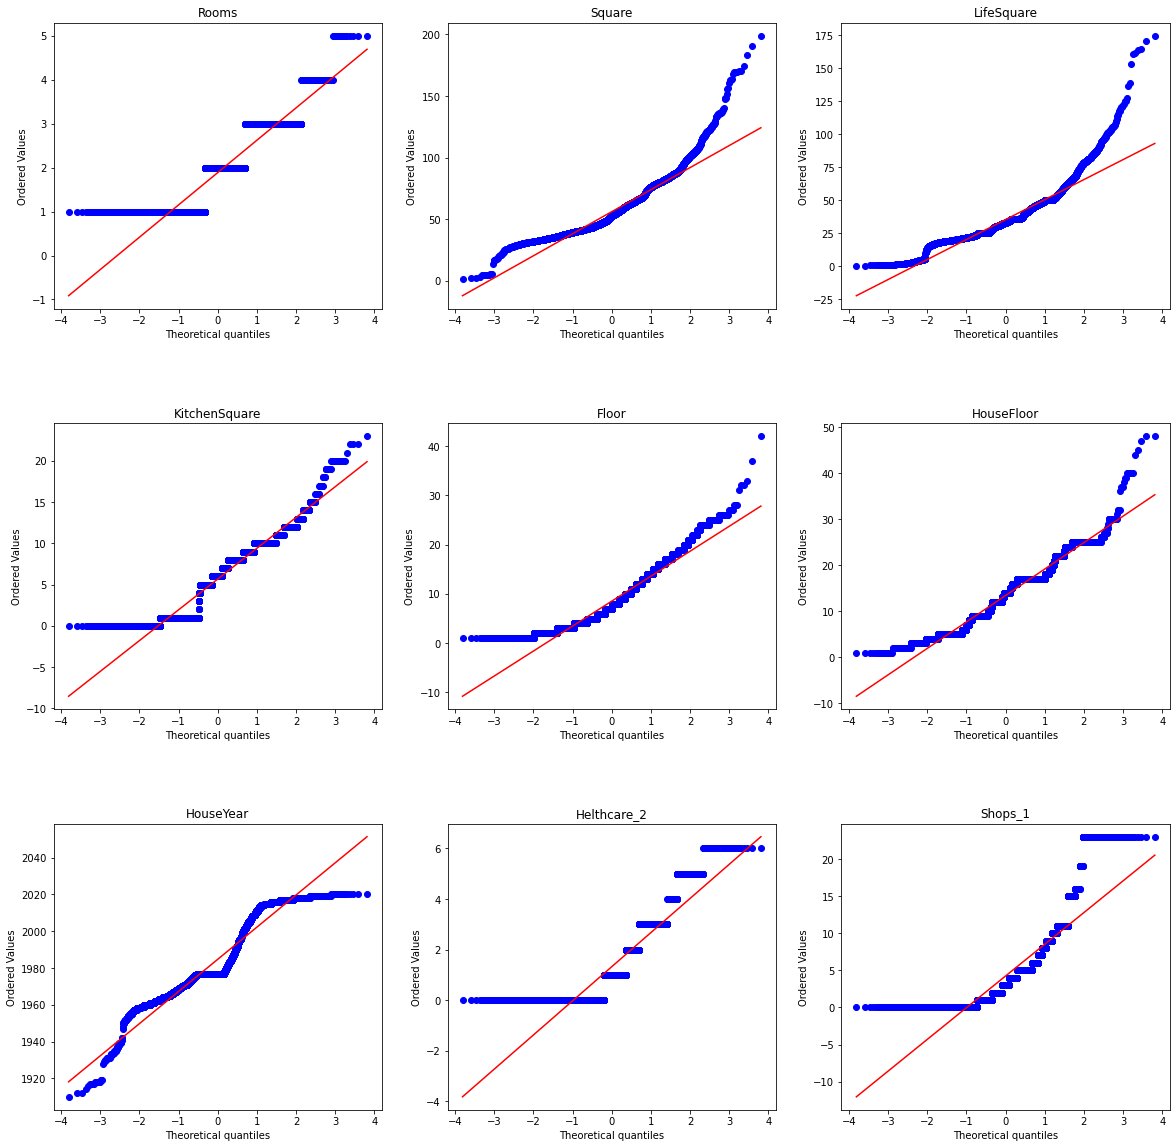

In [46]:
f, a = plt.subplots(3,3, figsize=(20,20))
a = a.flatten().T
f.subplots_adjust(wspace=0.2, hspace=0.4)
for i, col in enumerate(data[features].columns):
    stats.probplot(data[col], plot=a[i])
    a[i].set_title(col)
plt.show()

## Making extra feature

In [47]:
# ADDING A FEATURE PRICE/LIFESQUARE BY DISTRICT ID'S
# DROPPING PRICE FOR LIFESQUARE AFTER CAUSE WE DONT HAVE IT FOR TEST SET
data['price_for_lifesquare'] = data['Price']/data['LifeSquare']
mean_PFL_by_district = data.groupby('DistrictId')['price_for_lifesquare'].mean().to_dict()
unique_districts = data['DistrictId'].unique()
data['mean_PFL_by_district']= 0

for DistrictId in unique_districts:
    data.loc[data['DistrictId']==DistrictId, 'mean_PFL_by_district'] = mean_PFL_by_district.get(DistrictId)
data.drop('price_for_lifesquare', axis=1, inplace=True)

data.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price,Ecology_2,Ecology_3,Shops_2,mean_PFL_by_district
0,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,33,7976,5,0,11,184966.930730,1,1,1,7429.727815
1,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,46,10309,1,1,16,300009.450063,1,1,1,7276.141717
2,53,2,44.947953,29.197612,0.0,8,12,1968,0.049637,34,7759,0,1,3,220925.908524,1,1,1,8068.014496
3,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,23,5735,3,0,5,175616.227217,1,1,1,6062.415730
4,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,35,5776,1,2,4,150226.531644,1,1,1,6396.128885


In [48]:
# PFL FOR test data
data1['mean_PFL_by_district'] = 0
district_mean_pfl = data1['mean_PFL_by_district'].mean()
for DistrictId in unique_districts:
    data1.loc[data1['DistrictId']==DistrictId, 'mean_PFL_by_district'] = mean_PFL_by_district.get(DistrictId)
data1['mean_PFL_by_district'].fillna(district_mean_pfl, inplace=True)
data1.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2,Ecology_3,Shops_2,mean_PFL_by_district
0,58,2,49.882643,33.432782,6.0,6,14,1972,0.310199,11,2748,1,0,0,1,1,1,6062.415730
1,74,2,69.263183,35.618485,1.0,6,6,1977,0.075779,6,1437,3,0,2,1,1,1,9622.948663
2,190,1,13.597819,15.948246,12.0,2,5,1909,0.000000,30,7538,87,5,5,1,1,1,12249.172429
3,47,2,73.046609,51.940842,9.0,22,22,2007,0.101872,23,4583,3,3,3,1,1,1,7037.781276
4,27,1,47.527111,43.387569,1.0,17,17,2017,0.072158,2,629,1,0,0,1,1,0,7222.530230


## Splitting data

In [49]:
X = data.copy()
X_test = data1.copy()

In [50]:
y_train = X['Price']
X_train = X.drop('Price', axis=1)

In [51]:
X_test.shape

(5000, 18)

## Model making

In [52]:
XGB_model = XGBRegressor(n_estimators=300, learning_rate=0.05)

In [53]:
XGB_model.fit(X_train, y_train)
preds = XGB_model.predict(X_test)
preds

array([163229.48, 211814.83, 226150.92, ..., 322358.78, 197283.86,
       179277.14], dtype=float32)

In [54]:
predictions = pd.DataFrame(pd.read_csv('test.csv')['Id'])
predictions['Price']=preds
predictions.head()

,Id,Price
0,725,163229.484375
1,15856,211814.828125
2,5480,226150.921875
3,15664,338417.031250
4,14275,143054.343750


In [55]:
predictions.to_csv('course_preds', index=False)